In [20]:
import numpy as np
import matplotlib.pyplot as plt
import bilby
import pandas as pd
import dynesty
import joblib
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from matplotlib.colors import LogNorm
import multiprocessing
import corner as corner
from dynesty.utils import resample_equal
import healpy as hp
import arviz as az

In [3]:
SMALL_SIZE = 15+5
MEDIUM_SIZE = 20+5
BIGGER_SIZE = 25+5

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [4]:
duration = 4
sampling_frequency = 2048
t0_gps = 1126259460.4
n_samples = duration*sampling_frequency
time = np.linspace(0, duration, n_samples)

delta = 5
ras = np.radians(np.arange(0, 360, delta))
decs = np.radians(np.arange(-90, 90, delta))
ra_s = np.radians(np.linspace(-180, 180, len(ras)+1))
dec_s = np.radians(np.linspace(-90, 90, len(decs)+1))
radec_s = np.array([(ra, dec) for ra in ra_s for dec in dec_s])
radec = np.array([(ra, dec) for ra in ras for dec in decs])
radec_map = radec.reshape(36, 72, 2)

In [5]:
data = joblib.load('output/data.pkl')

In [6]:
IFOH = bilby.gw.detector.InterferometerList(['H1'])[0]
IFOH.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=data['h1_psd']['Hz'], psd_array=data['h1_psd']['PSD'])
# IFOH.frequency_array = h1_psd['Hz']

IFOL = bilby.gw.detector.InterferometerList(['L1'])[0]
IFOL.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=data['l1_psd']['Hz'], psd_array=data['l1_psd']['PSD'])
# IFOL.frequency_array = l1_psd['Hz']

IFOV = bilby.gw.detector.InterferometerList(['V1'])[0]
IFOV.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=data['v1_psd']['Hz'], psd_array=data['v1_psd']['PSD'])
# IFOV.frequency_array = v1_psd['Hz']

In [36]:
def priors(params):
    """
    Transform unit hypercube parameters into physical prior ranges.

    Args:
        params (array): Array of unit hypercube parameters.
    Returns:
        np.array: Transformed parameters in physical units: RA (rad), Dec (rad), polarization angle (rad), geocentric time of coalescence (s), and luminosity distance (Gpc).
    """
    ra, dec, psi, tc_geo, dl = params
    return np.array([ra*2*np.pi, np.arcsin(2*dec-1), psi*np.pi, tc_geo*4, 1e-4*(1000/1e-3)**dl])

def log_likelihood(params):
    """
    Compute log-likelihood of GW signal given the parameters.

    Args:
        params (array): Array of parameters [ra, dec, psi, tc_geo, DL], RA (rad), Dec (rad), polarization angle (rad), geocentric time of coalescence (s), and luminosity distance (Gpc).
    Returns:
        float: Log-likelihood value.
    """
    ra, dec, psi, tc_geo, DL = params
    
    logl = 0

    for strain, IFO in zip(strains, IFOS):
        asd = IFO.power_spectral_density.asd_array
        asd[~mask] = np.inf
        fplus = IFO.antenna_response(ra=ra, dec=dec, time=t0_gps, psi=psi, mode='plus')
        fcross = IFO.antenna_response(ra=ra, dec=dec, time=t0_gps, psi=psi, mode='cross')
        template = data['waveform']['h+'] * fplus + data['waveform']['hx'] * fcross
        delay = tc_geo + IFO.time_delay_from_geocenter(ra, dec, t0_gps)
        phase_shift = np.exp(-1j * 2*np.pi * data['waveform']['Hz'] * delay)
        h = template * phase_shift
        h /= DL
        res = strain['h'] - h
        logl -= 2 * np.sum(((res * np.conj(res)) / asd**2) * df)

    return logl.real

def plot_corner(sampler, flag):
    """
    Plot the corner plot of the posterior samples.
    Args:
        sampler (dynesty.NestedSampler): The sampler object containing the results.
        flag (str): A flag to identify the plot and output files.
    Returns:
        np.ndarray: Array of equal-weight resampled posterior samples.
    """
    result = sampler.results
    samples = result.samples
    weights = np.exp(result.logwt - result.logz[-1])
    equal_samples = resample_equal(samples, weights)
    psi_samples = equal_samples[:, 2]
    psi_centered = (psi_samples + np.pi/2) % np.pi - np.pi/2
    equal_samples[:, 2] = psi_centered

    fig = corner.corner(
        equal_samples,
        labels=[r"$\alpha$", r"$\delta$", r"$\psi$", r"$t_c^{geo}$", r"$D_L$"],
        quantiles=[0.05, 0.5, 0.95],
        show_titles=True,
        title_kwargs={"fontsize": 17},
        title_fmt='.2f' if flag == 'HLV' else '.1f',
        color='blue',
        label_kwargs={"fontsize": 17},
        labelpad=0.1,
        levels=[0.68, 0.998]
    )

    for ax in fig.axes:
        ax.tick_params(axis='both', which='major', labelsize=14)  

    axes = np.array(fig.axes).reshape((5, 5))

    ax_tc = axes[3, 3] 
    ax_dl = axes[4, 4]

    # Get the sample values
    tc_samples = equal_samples[:, 3]
    tc_median = np.median(tc_samples)
    tc_hpd = az.hdi(tc_samples, hdi_prob=0.90)
    tc_qs = [tc_hpd[0], tc_median, tc_hpd[1]]
    tc_title = f"$t_c^{{geo}}=${tc_qs[1]:.3f}$_{{{tc_qs[1]-tc_qs[0]:.3f}}}^{{{tc_qs[2]-tc_qs[1]:.3f}}}$"  # median with 1 decimal
    # tc_title += f"\n[{tc_qs[0]:.2f}, {tc_qs[2]:.2f}]"  # 90% interval

    # Set the new title
    ax_tc.set_title(tc_title, fontsize=17)

    dl_samples = equal_samples[:, 4]
    dl_median = np.median(dl_samples)
    dl_hpd = az.hdi(dl_samples, hdi_prob=0.90)
    dl_qs = [dl_hpd[0], dl_median, dl_hpd[1]]
    dl_title = f"$D_L=${dl_qs[1]:.2f}$_{{{dl_qs[1]-dl_qs[0]:.2f}}}^{{{dl_qs[2]-dl_qs[1]:.2f}}}$"  # median with 1 decimal
    ax_dl.set_title(dl_title, fontsize=17)

    plt.savefig(f'figures/corner_{flag}.png', dpi=300, bbox_inches='tight')

    joblib.dump(equal_samples, f'output/equal_samples_{flag}.pkl')

    return equal_samples

def plot_map(equal_samples, flag):
    """
    Plot RA and Dec posterior probability map using Healpy.
    Args:
        equal_samples (np.ndarray): Array of equal-weight resampled posterior samples.
        flag (str): A flag to identify the plot and output files.
    Returns:
        None
    """
    ra_samples = equal_samples[:, 0]
    dec_samples = equal_samples[:, 1]

    nside = 64

    theta = np.pi/2 - dec_samples
    phi = ra_samples

    pixels = hp.ang2pix(nside, theta, phi)

    prob_map = np.bincount(pixels, minlength=hp.nside2npix(nside))
    prob_map = prob_map / np.sum(prob_map)

    hp.newvisufunc.projview(prob_map, 
                            coord=["C"],
                            graticule=True, 
                            graticule_labels=True,
                            projection_type="mollweide",
                            xlabel="RA (rad)",
                            ylabel="Dec (rad)",
                            latitude_grid_spacing=15,
                            longitude_grid_spacing=30,
                            cb_orientation="vertical",
                            cmap='viridis_r',
                            )
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
    ax.set_ylabel("Dec (rad)", fontsize=MEDIUM_SIZE)
    ax.set_xlabel("RA (rad)", fontsize=MEDIUM_SIZE)
    max_idx = np.argmax(prob_map)
    max_theta, max_phi = hp.pix2ang(nside, max_idx)
    max_dec = np.pi/2 - max_theta
    max_ra = max_phi

    fig = plt.gcf()
    cbar = fig.axes[-1]  # The last axis is usually the colorbar
    cbar.tick_params(labelsize=SMALL_SIZE)  # Change this to desired font size
    cbar.set_ylabel("Probability", fontsize=MEDIUM_SIZE)


    max_ra_deg = np.rad2deg(max_ra)
    max_dec_deg = np.rad2deg(max_dec)
    print(f"Most probable location: RA = {max_ra_deg:.2f} deg, Dec = {max_dec_deg:.2f} deg")

    prob_sorted = np.sort(prob_map)[::-1]
    cumulative_prob = np.cumsum(prob_sorted)

    threshold = 0.9
    threshold_idx = np.searchsorted(cumulative_prob, threshold)
    threshold_value = prob_sorted[threshold_idx]
    pix_area = hp.nside2pixarea(nside, degrees=True)
    area = np.sum(prob_map >= threshold_value) * pix_area
    print(f"Area enclosing {threshold*100}% of posterior probability: {area:.2f} square degrees")

    max_ra_wrapped = max_ra_deg if max_ra_deg <= 180 else max_ra_deg - 360

    hp.newvisufunc.newprojplot(max_ra_wrapped, max_dec_deg, 'ro', lonlat=True, markersize=2)

    plt.savefig(f"figures/posterior_map_{flag}.png", bbox_inches='tight', dpi=300)
    plt.show()

In [37]:
def table(equal_samples):
    hdi_results = []
    labels = [r"$\alpha$", r"$\delta$", r"$\psi$", r"$t_c^{geo}$", r"$D_L$"]

    for i in range(equal_samples.shape[1]):
        samples = equal_samples[:, i]
        median = np.median(samples)
        hdi = az.hdi(samples, hdi_prob=0.68)
        lower_err = median - hdi[0]
        upper_err = hdi[1] - median
        hdi_results.append({
            "label": labels[i],
            "median": median,
            "hdi": hdi,
            "lower_err": lower_err,
            "upper_err": upper_err
        })

    # Optional: print nicely
    for res in hdi_results:
        print(
            f"{res['label']}: {res['median']:.3f}"
            f" (-{res['lower_err']:.3f}, +{res['upper_err']:.3f})"
            f" [HPD: {res['hdi'][0]:.3f}, {res['hdi'][1]:.3f}]"
        )


In [8]:
IFOS = [IFOH, IFOL]#, IFOV]
strains = [data['h1_strain'], data['l1_strain']]#, data['v1_strain']]
mask = data['waveform']['Hz'] > 20
df = data['waveform']['Hz'][1] - data['waveform']['Hz'][0]

In [9]:
sampler = dynesty.DynamicNestedSampler(
    log_likelihood,
    priors,
    ndim=5,
    nlive=1000,    
    bound="multi", 
    sample="rwalk",
    queue_size=multiprocessing.cpu_count(),
    pool=multiprocessing.Pool(processes=multiprocessing.cpu_count()),
    periodic=[0,2],
    rstate=np.random.default_rng(seed=441),
)
sampler.run_nested(dlogz_init=0.01, print_progress=True)

34669it [01:46, 325.54it/s, batch: 2 | bound: 3 | nc: 1 | ncall: 770680 | eff(%):  4.363 | loglstar: -7898.868 < -7894.729 < -7898.254 | logz: -7919.435 +/-  0.128 | stop:  0.893]        


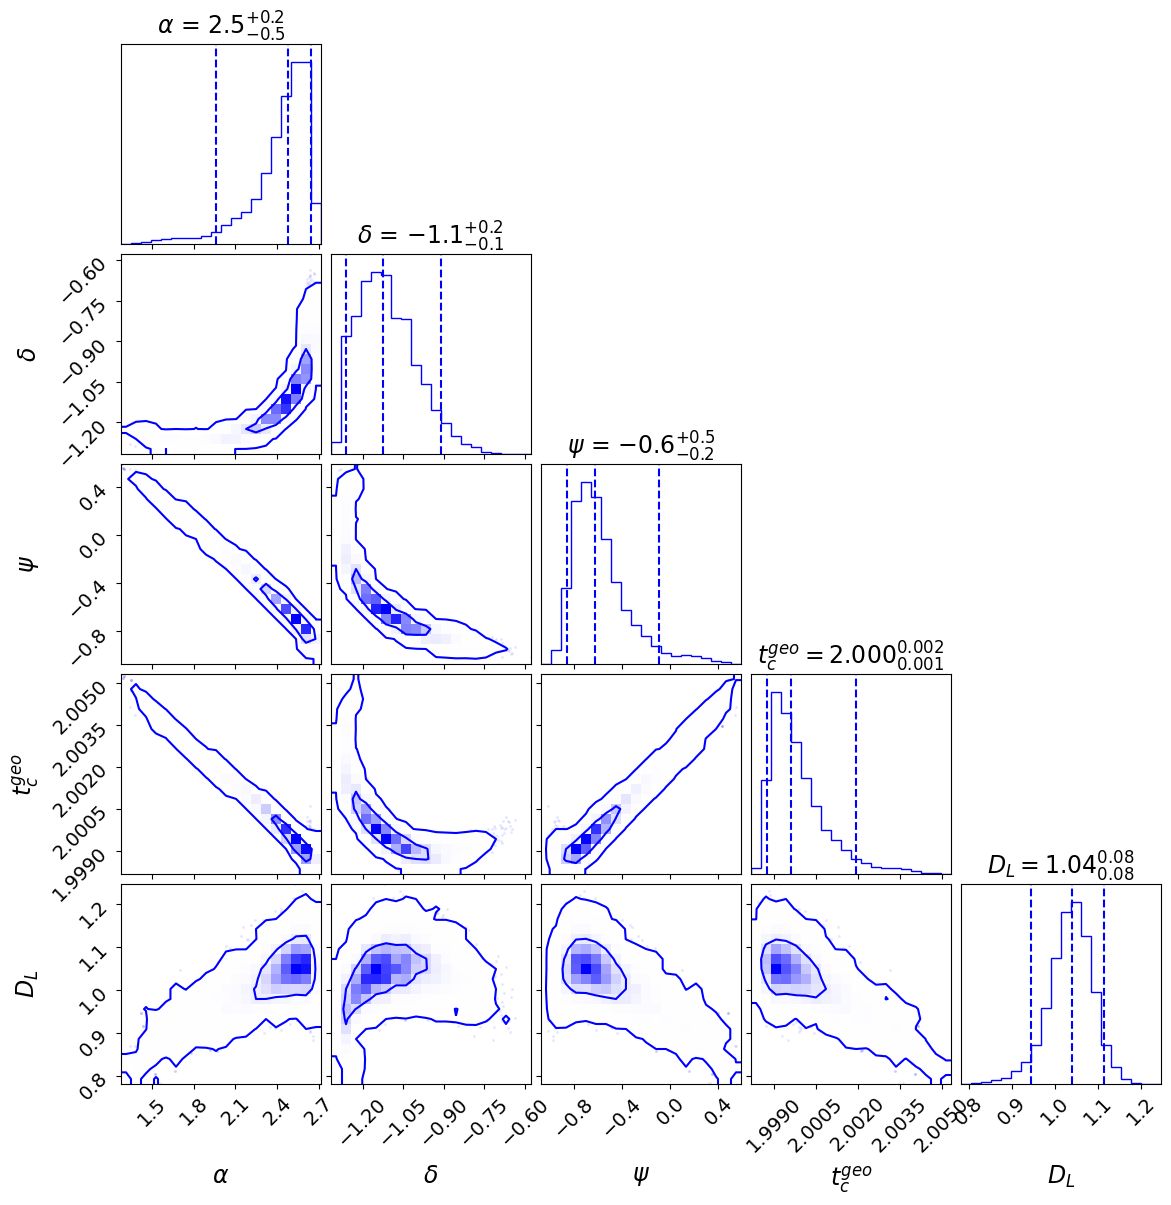

In [41]:
equal_samples = plot_corner(sampler, 'HL')

In [38]:
table(equal_samples)

$\alpha$: 2.476 (-0.100, +0.180) [HPD: 2.376, 2.657]
$\delta$: -1.123 (-0.132, +0.080) [HPD: -1.255, -1.043]
$\psi$: -0.629 (-0.224, +0.139) [HPD: -0.853, -0.491]
$t_c^{geo}$: 2.000 (-0.001, +0.001) [HPD: 1.999, 2.000]
$D_L$: 1.039 (-0.044, +0.051) [HPD: 0.995, 1.090]


Most probable location: RA = 141.62 deg, Dec = -64.95 deg
Area enclosing 90.0% of posterior probability: 93.16 square degrees


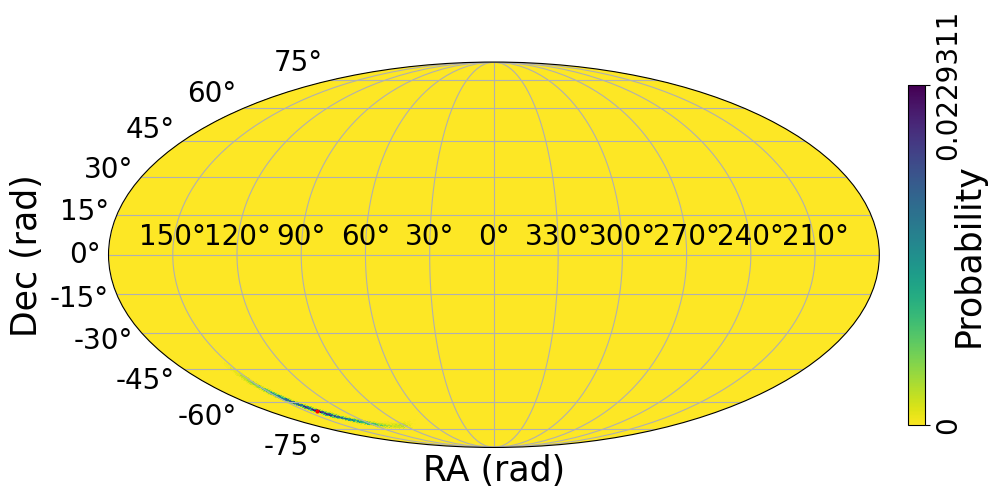

In [11]:
plot_map(equal_samples, 'HL')

In [12]:
IFOS = [IFOH, IFOL, IFOV]
strains = [data['h1_strain'], data['l1_strain'], data['v1_strain']]

sampler2 = dynesty.DynamicNestedSampler(
    log_likelihood,
    priors,
    ndim=5,
    nlive=1000,    
    bound="multi", 
    sample="rwalk",
    queue_size=multiprocessing.cpu_count(),
    pool=multiprocessing.Pool(processes=multiprocessing.cpu_count()),
    periodic=[0,2],
    rstate=np.random.default_rng(seed=441),
)
sampler2.run_nested(dlogz_init=0.01, print_progress=True)

45137it [03:13, 233.63it/s, batch: 2 | bound: 3 | nc: 1 | ncall: 1033200 | eff(%):  4.269 | loglstar: -11917.486 < -11913.624 < -11916.859 | logz: -11948.403 +/-  0.156 | stop:  0.877]     


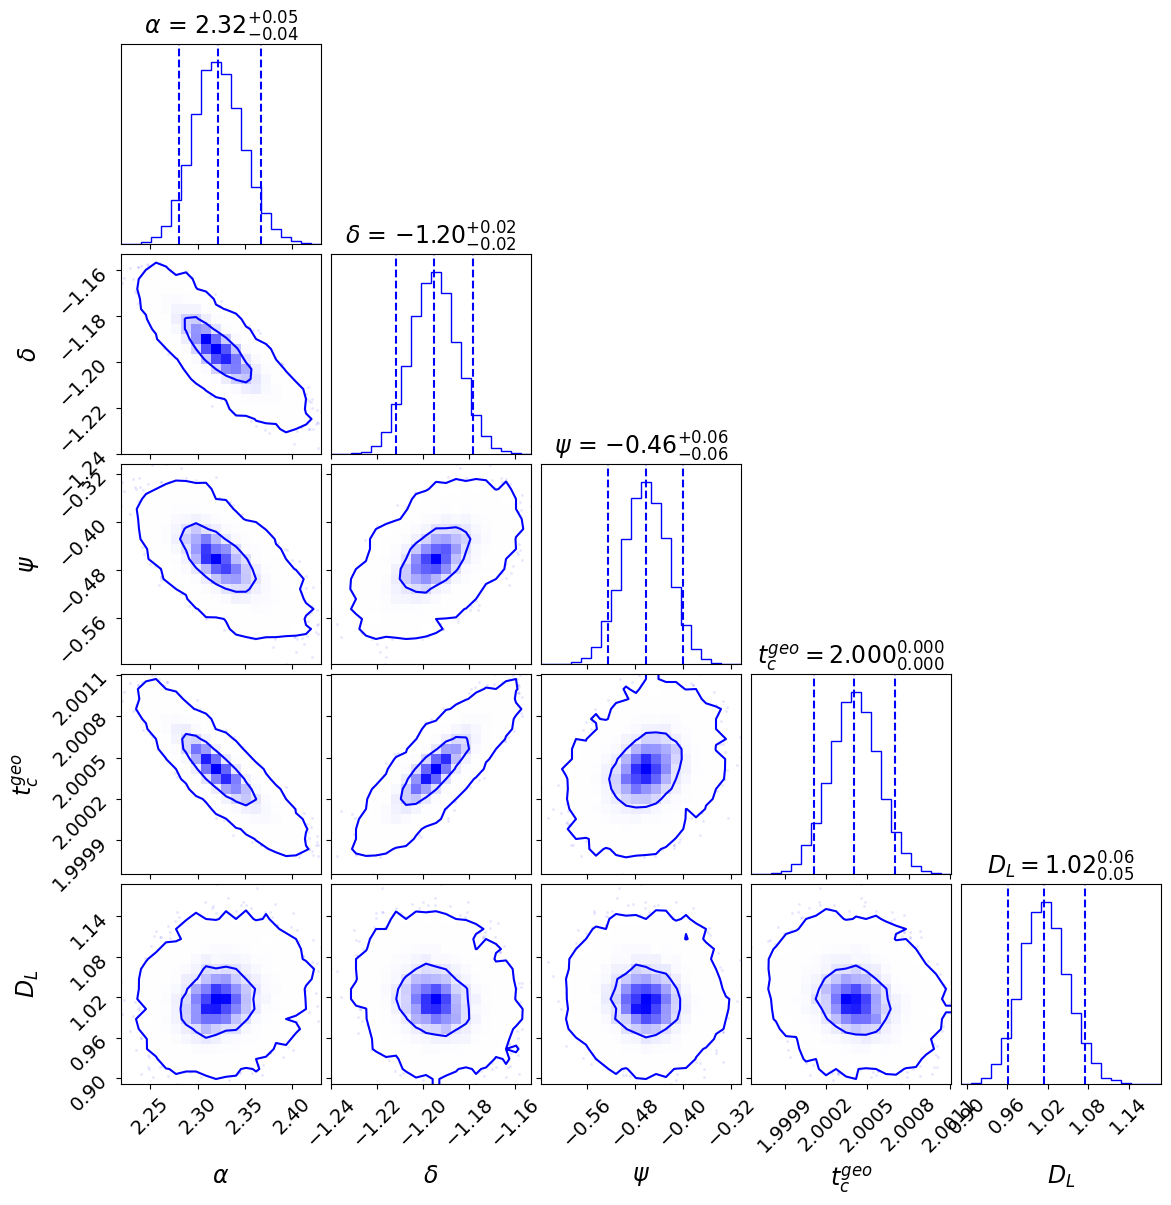

In [40]:
equal_samples2 = plot_corner(sampler2, 'HLV')

In [39]:
table(equal_samples2)

$\alpha$: 2.321 (-0.026, +0.026) [HPD: 2.295, 2.347]
$\delta$: -1.195 (-0.010, +0.010) [HPD: -1.205, -1.185]
$\psi$: -0.462 (-0.036, +0.039) [HPD: -0.498, -0.423]
$t_c^{geo}$: 2.000 (-0.000, +0.000) [HPD: 2.000, 2.001]
$D_L$: 1.015 (-0.035, +0.034) [HPD: 0.980, 1.049]


Most probable location: RA = 131.90 deg, Dec = -68.68 deg
Area enclosing 90.0% of posterior probability: 5.04 square degrees


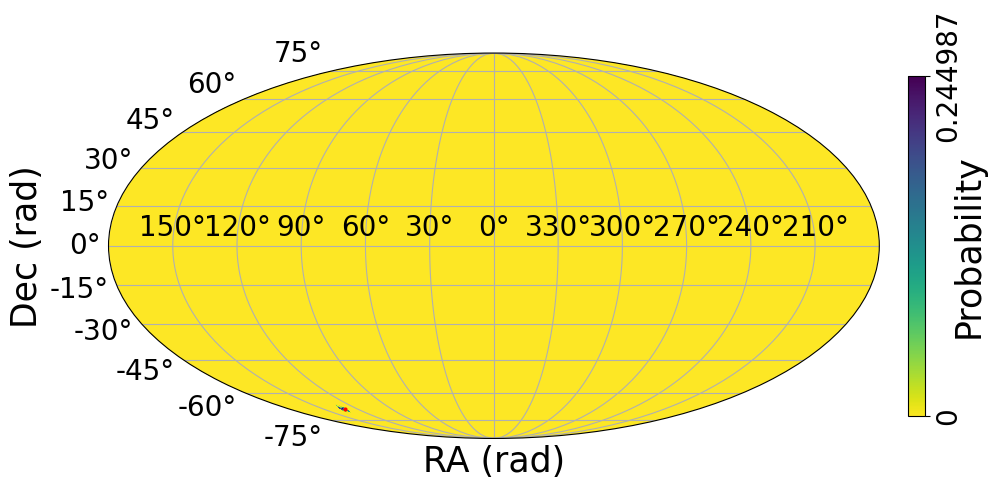

In [14]:
plot_map(equal_samples2, 'HLV')